In [1]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from C:\Users\uabhi\NEW_MY_JUPYTER\BCI\BCI 4 dataset\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\uabhi\anaconda3\envs\tf\lib\contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

**From the paper**  
'1023': 1 (Rejected trial),   
 '1072': 2 (Eye movements),  
 '276':  3 (eyes open)),  
 '277':  4 (eyes closed),   
 '32766':5 (Start of a new run),  
 '768':  6 (Start of a trial),  
 '769': 7 (class 1),  
 '770': 8 (class 2),  
 '771': 9 (class 3),  
 '772': 10 (class 4)
#### event ids are not same for all subjects

In [56]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[769,770],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [57]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [58]:
%%capture
features,labels,groups=[],[],[]
for i in range(len(paths)):
    feature,label=read_data(paths[i])
    features.append(feature)
    labels.append(label)
    groups.append([i+1]*len(label))

In [59]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((1296, 22, 1001), (1296,), (1296,))

In [60]:
groups

array([1, 1, 1, ..., 9, 9, 9])

In [61]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

In [62]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts


(array([769, 770]), array([648, 648], dtype=int64))

# Tensor preparation

In [63]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [64]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [65]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [66]:
np.unique(labels)

array([0, 1])

In [67]:
data_array = features
label_array = labels
group_array = groups
data_array=np.moveaxis(data_array,1,2)

accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    break

In [68]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.2, random_state=42)
a,b,train_gr,val_gr = train_test_split(data_array, group_array, test_size=0.2, random_state=42)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [69]:
train_gr

array([3, 9, 9, ..., 8, 6, 8])

In [70]:
train_features.shape, train_labels.shape

((1036, 1001, 22), (1036, 1))

In [71]:
train_features=np.moveaxis(train_features,1,2)
val_features =np.moveaxis(val_features,1,2)

In [72]:
train_features.shape, train_features.shape

((1036, 22, 1001), (1036, 22, 1001))

In [73]:
from EEGModels_binary_classifiers import *
import tensorflow as tf

# EegNet

In [102]:
eegnet = EEGNet(1, features.shape[1],features.shape[2],dropoutRate = 0.2)
#eegnet = tf.keras.models.load_model('Models/eegnet_LT_0.9000.h5')
eegnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 1001, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 1001, 8)       512       
                                                                 
 batch_normalization_3 (Batc  (None, 22, 1001, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 1001, 16)      352       
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 1001, 16)      64        
 hNormalization)                                                 
                                                           

In [103]:
eegnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = 'binary_crossentropy',metrics=['accuracy'])

In [108]:
eegnet_history = eegnet.fit(train_features, train_labels,epochs=10,batch_size=36,validation_data=(val_features, val_labels))

Epoch 1/10
29/29 [==============================] - 9s 297ms/step - loss: 0.2409 - accuracy: 0.9122 - val_loss: 0.3110 - val_accuracy: 0.8692
Epoch 2/10
29/29 [==============================] - 9s 311ms/step - loss: 0.2239 - accuracy: 0.9276 - val_loss: 0.3707 - val_accuracy: 0.8615
Epoch 3/10
29/29 [==============================] - 10s 353ms/step - loss: 0.2189 - accuracy: 0.9237 - val_loss: 0.3536 - val_accuracy: 0.8654
Epoch 4/10
29/29 [==============================] - 9s 320ms/step - loss: 0.2450 - accuracy: 0.9006 - val_loss: 0.4186 - val_accuracy: 0.8154
Epoch 5/10
29/29 [==============================] - 9s 320ms/step - loss: 0.2270 - accuracy: 0.9112 - val_loss: 0.3828 - val_accuracy: 0.8423
Epoch 6/10
29/29 [==============================] - 10s 330ms/step - loss: 0.2330 - accuracy: 0.9035 - val_loss: 0.3749 - val_accuracy: 0.8308
Epoch 7/10
29/29 [==============================] - 9s 313ms/step - loss: 0.2122 - accuracy: 0.9286 - val_loss: 0.3240 - val_accuracy: 0.8538
Epoc

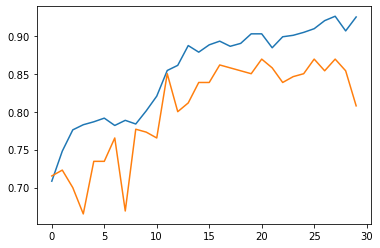

In [106]:
plt.plot(eegnet_history.history["accuracy"])
plt.plot(eegnet_history.history["val_accuracy"])

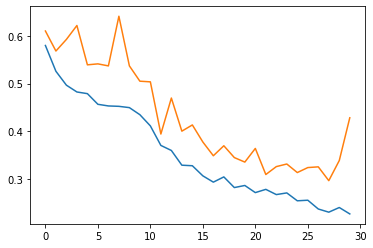

In [107]:
plt.plot(eegnet_history.history["loss"])
plt.plot(eegnet_history.history["val_loss"])

# Binary Class Class accuaracies

In [79]:
train_features.shape

(1036, 22, 1001)

In [80]:
train_labels.shape[0]

1036

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       502
           1       0.91      0.98      0.94       534

    accuracy                           0.94      1036
   macro avg       0.94      0.94      0.94      1036
weighted avg       0.94      0.94      0.94      1036



<AxesSubplot:>

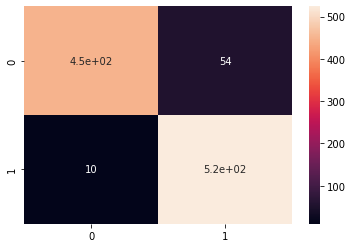

In [81]:
# classification report on training set
y_p = []
pred = eegnet.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.98      0.81      0.88       146
           1       0.80      0.97      0.88       114

    accuracy                           0.88       260
   macro avg       0.89      0.89      0.88       260
weighted avg       0.90      0.88      0.88       260



<AxesSubplot:>

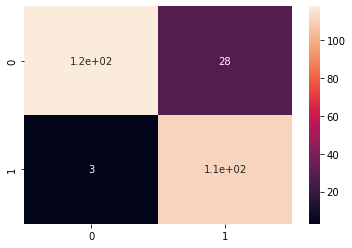

In [82]:
# classification report on validation set
y_p = []
pred = eegnet.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

# DeepConvNet

In [22]:
deepconvnet = DeepConvNet(1, features.shape[1],features.shape[2],dropoutRate = 0.5)
deepconvnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 1001, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 22, 997, 25)       150       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 997, 25)        13775     
                                                                 
 batch_normalization (BatchN  (None, 1, 997, 25)       100       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 997, 25)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 498, 25)       0         
 )                                                           

In [23]:
deepconvnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = 'binary_crossentropy',metrics=['accuracy'])

In [83]:
deepconvnet_history = deepconvnet.fit(train_features, train_labels,epochs=1,batch_size=40,validation_data=(val_features, val_labels))

26/26 [==============================] - 16s 609ms/step - loss: 0.1568 - accuracy: 0.9315 - val_loss: 0.2662 - val_accuracy: 0.8808


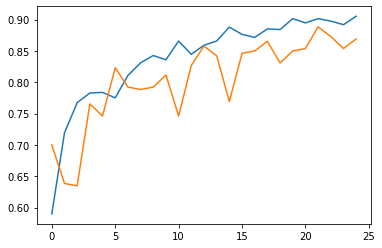

In [25]:
plt.plot(deepconvnet_history.history["accuracy"])
plt.plot(deepconvnet_history.history["val_accuracy"])

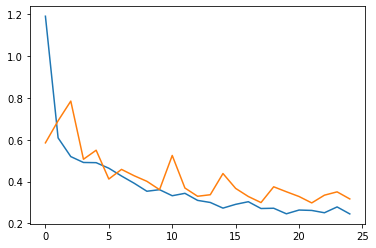

In [26]:
plt.plot(deepconvnet_history.history["loss"])
plt.plot(deepconvnet_history.history["val_loss"])